In [1]:
%pylab inline
import scipy.integrate as integrate
from IPython import display
matplotlib.rcParams.update({'errorbar.capsize': 2})
import time

Populating the interactive namespace from numpy and matplotlib


1.0 0.01
1.0 0.1
1.0 1.0
1.0 10.0
1.0 100.0


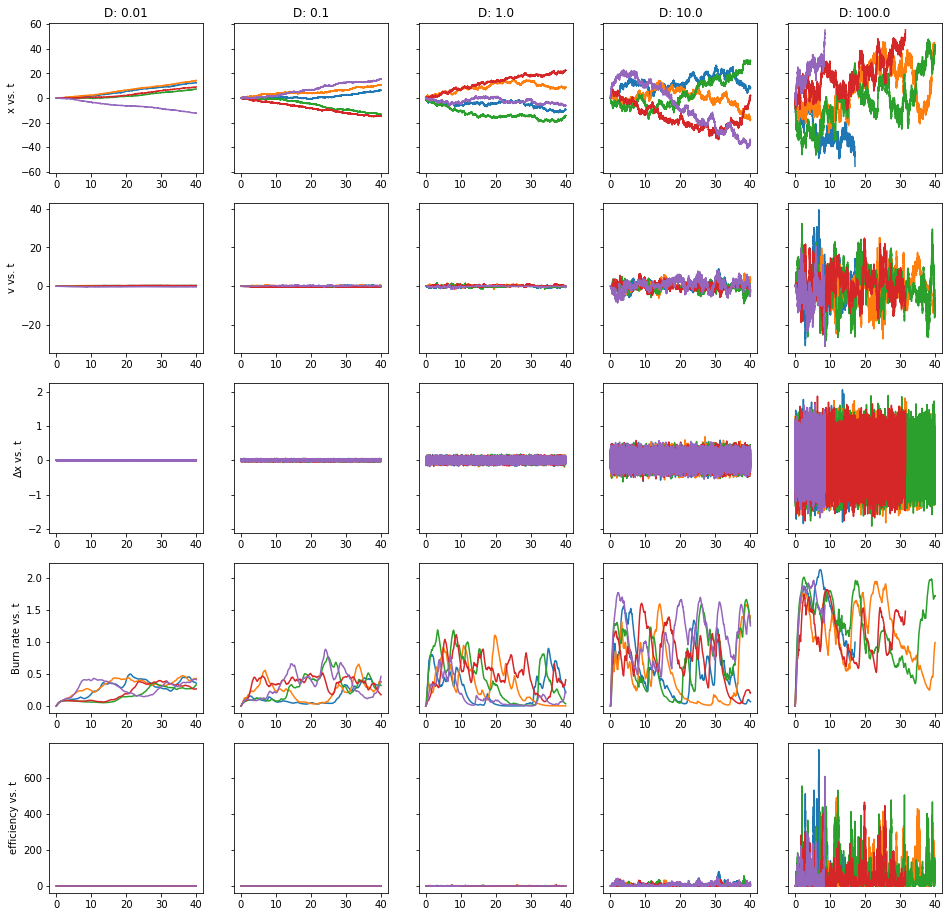

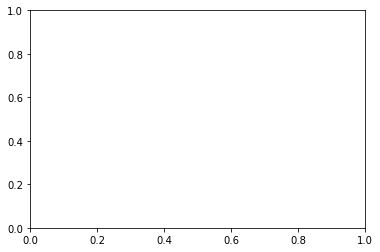

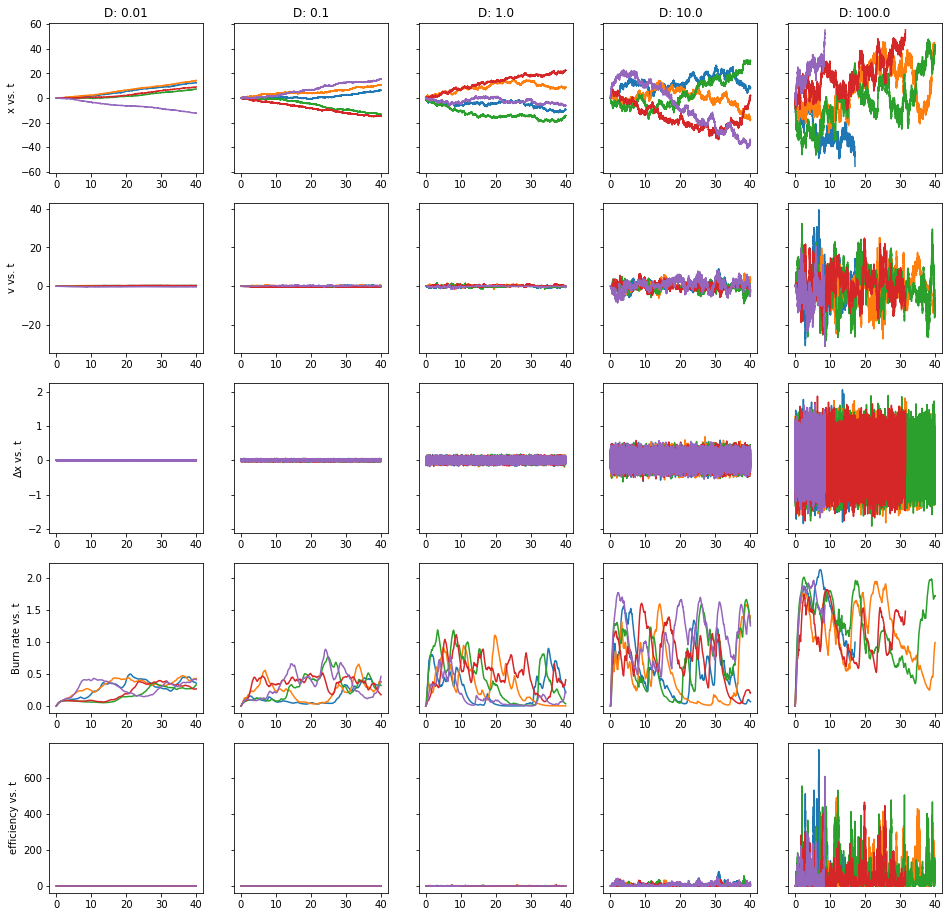

In [6]:
# vary D without force unbinding

length = 60.0
Lmax = length
Lmin = -length
dx = 0.1
Nx = int((Lmax-Lmin)/dx) +1
xs = linspace(Lmin, Lmax, Nx)

run_n = 5
nu = 1.0
sol_0 = []
bean_0 = []
D_n = 5
Ds = logspace(-2,2,D_n,base = 10)

dt = 0.001

for a0 in ones(1):
    ct = 0 
    display.clear_output(wait=True)
    cla()
    fig, axs = plt.subplots(5,D_n,sharey="row",figsize = (16,16))
    
    for D in Ds: 
        print(a0,D)
        tf = 40.0

        
        for run in range(run_n):

            xp = 0.0
            Ac = zeros(Nx)
            As = zeros(Nx) 
            As[xs > 2.0] = a0
            As[xs < -2.0] =a0
            
            t_max = int(tf/dt)
            xp_t = []
            As_t = []
            Ac_t = []
            v_t = []
            burn_t = []
            noisescale = sqrt(2*dt*D)
            for t in range(t_max): ## loop through for every time step
                ## first determine total force on hub

                
                
                total_f = trapz(-(xp -xs) * Ac, x=xs)
                binding = exp(-0.5 * (xp - xs) ** 2) * As
                burnt = nu * Ac
                Ac += (binding - burnt) *dt
                As += (- binding) * dt
                noise = noisescale* random.normal(0.0,1.0)
                xp += total_f * dt + noise 
                
                
                xp_t.append(xp)
                v_t.append(total_f)
                As_t.append(As.copy())
                Ac_t.append(Ac.copy())
                burn_t.append(trapz(Ac*nu,x=xs))
                
                if abs(xp) > length -5.0:
                    t_max = int(t)+1
                    break
                
            
            ts = linspace(0,t_max*dt,t_max)
            #suptitle("D: " +str(round(D,4)))
            axs[0][ct].plot(ts,xp_t)
            axs[0][ct].title.set_text("D: "+str(round(D,3)))
            axs[1][ct].plot(ts,v_t)
            axs[2][ct].plot(ts[1:],np.diff(array(xp_t)))
            axs[3][ct].plot(ts,burn_t)
            axs[4][ct].plot(ts,array(v_t)**2/array(burn_t))
            if ct == 0:
                axs[0][ct].set_ylabel('x vs. t')
                axs[1][ct].set_ylabel('v vs. t')
                axs[2][ct].set_ylabel('$\Delta$x vs. t')
                axs[3][ct].set_ylabel('Burn rate vs. t')
                axs[4][ct].set_ylabel('efficiency vs. t')
            
        ct += 1
display.display(gcf())
    





1.0 0.01
1.0 0.1
1.0 1.0
1.0 10.0
1.0 100.0


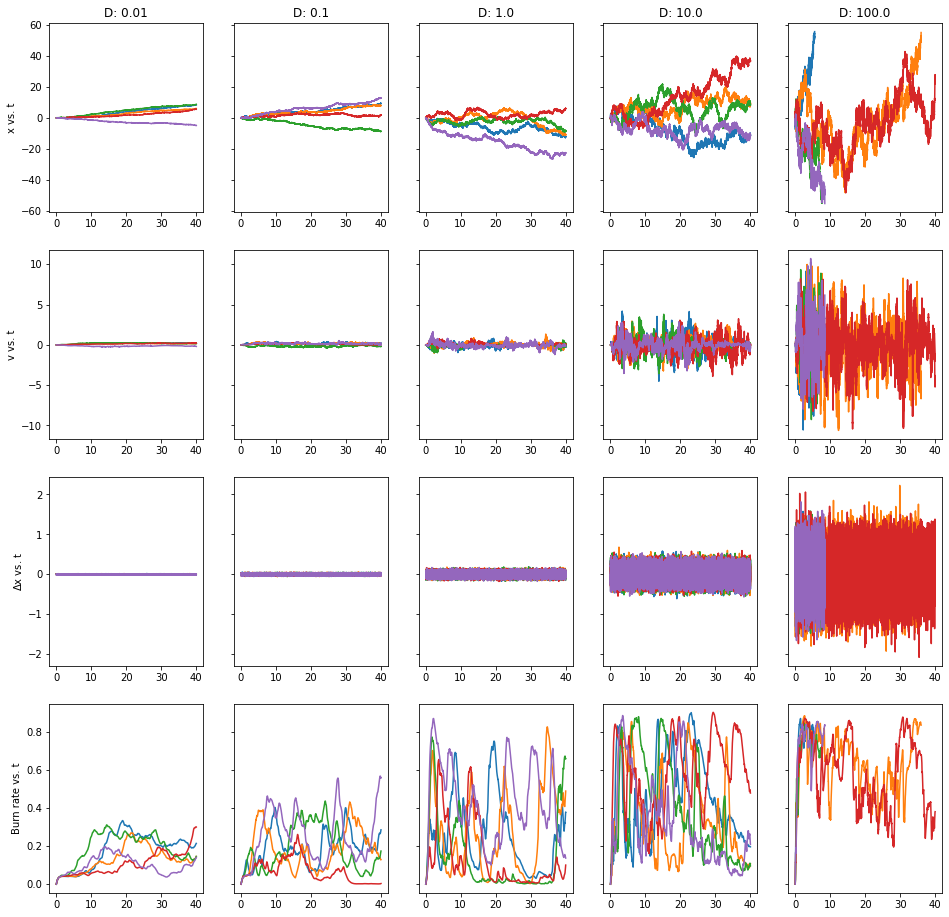

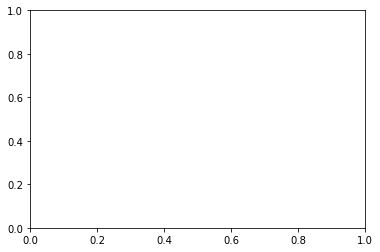

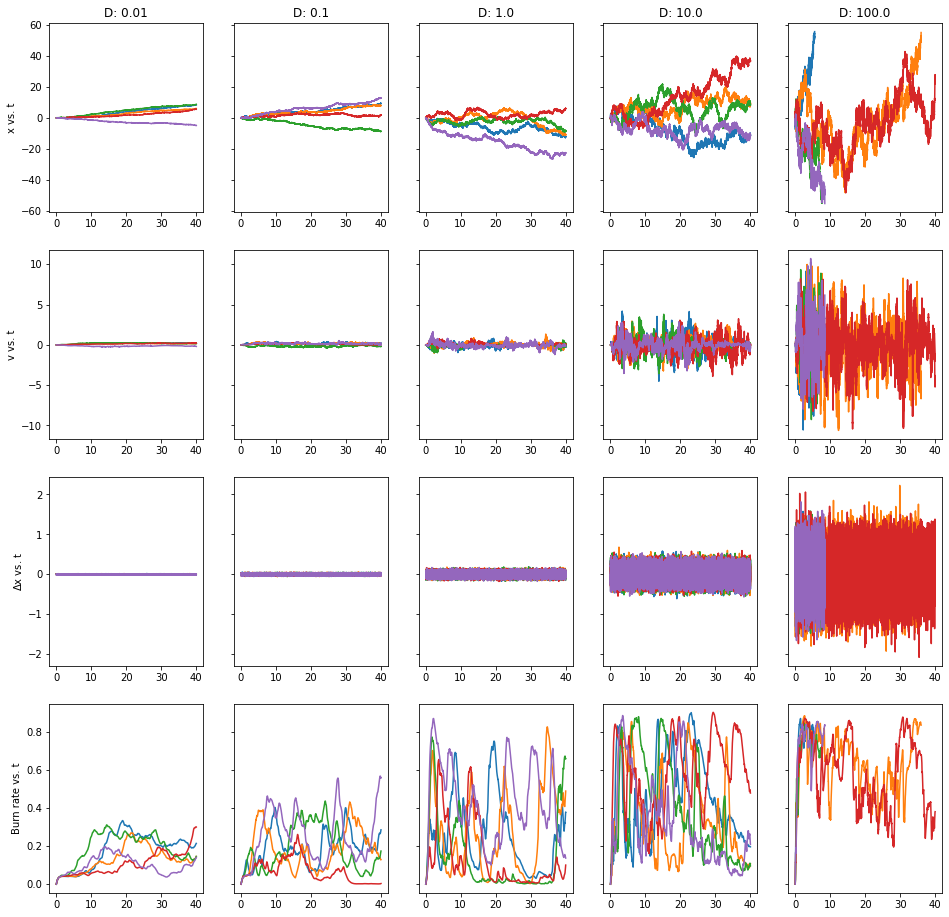

In [3]:
# vary D with force unbinding

length = 60.0
Lmax = length
Lmin = -length
dx = 0.1
Nx = int((Lmax-Lmin)/dx) +1
xs = linspace(Lmin, Lmax, Nx)

run_n = 5
nu = 1.0
D_n = 5
Ds = logspace(-2,2,D_n,base = 10)

dt = 0.001
w0 = 1.0
delta = 0.1

for a0 in ones(1):
    ct = 0 
    display.clear_output(wait=True)
    cla()
    fig, axs = plt.subplots(4,D_n,sharey="row",figsize = (16,16))
    
    for D in Ds: 
        print(a0,D)
        tf = 40.0

        
        for run in range(run_n):

            xp = 0.0
            Ac = zeros(Nx)
            As = zeros(Nx) 
            As[xs > 2.0] = a0
            As[xs < -2.0] =a0
            
            t_max = int(tf/dt)
            xp_t = []
            As_t = []
            Ac_t = []
            v_t = []
            burn_t = []
            count = 0
            noisescale = sqrt(2*dt*D)
            for t in range(t_max): ## loop through for every time step
                ## first determine total force on hub

                eps = 1e-8
                jj = where(Ac < eps)[0] # check where Acx is very small (and log(Acx) will be a problem)
                Ac_temp = Ac.copy()    # make a temporary copy, so that Acx does not need to be changed
                Ac_temp[jj] = 1e-10      
                err = (log(eps)-log(Ac_temp))
                wr = zeros(Nx)
                ii = where(err < 0.0)[0]
                wr[ii] = w0*Ac[ii]
                force_unbinding = wr * exp(abs(xp - xs) * delta)
                
                total_f = trapz(-(xp -xs) * Ac, x=xs)
                binding = exp(-0.5 * (xp - xs) ** 2) * As
                burnt = nu * Ac
                Ac += (binding - burnt - force_unbinding) *dt
                As += (- binding + force_unbinding) * dt
                noise = noisescale* random.normal(0.0,1.0)
                xp += total_f * dt + noise 
                
                
                xp_t.append(xp)
                v_t.append(total_f)
                As_t.append(As.copy())
                Ac_t.append(Ac.copy())
                burn_t.append(trapz(Ac*nu,x=xs))
                
                if abs(xp) > length -5.0:
                    t_max = int(t)+1
                    break
                
            
            ts = linspace(0,t_max*dt,t_max)
            #suptitle("D: " +str(round(D,4)))
            axs[0][ct].plot(ts,xp_t)
            axs[0][ct].title.set_text("D: "+str(round(D,3)))
            axs[1][ct].plot(ts,v_t)
            axs[2][ct].plot(ts[1:],np.diff(array(xp_t)))
            axs[3][ct].plot(ts,burn_t)
            if ct == 0:
                axs[0][ct].set_ylabel('x vs. t')
                axs[1][ct].set_ylabel('v vs. t')
                axs[2][ct].set_ylabel('$\Delta$x vs. t')
                axs[3][ct].set_ylabel('Burn rate vs. t')
            
        ct += 1
    display.display(gcf())
    





1.0 1.0
1.0 0.1
1.0 0.01
1.0 0.001
1.0 0.0001


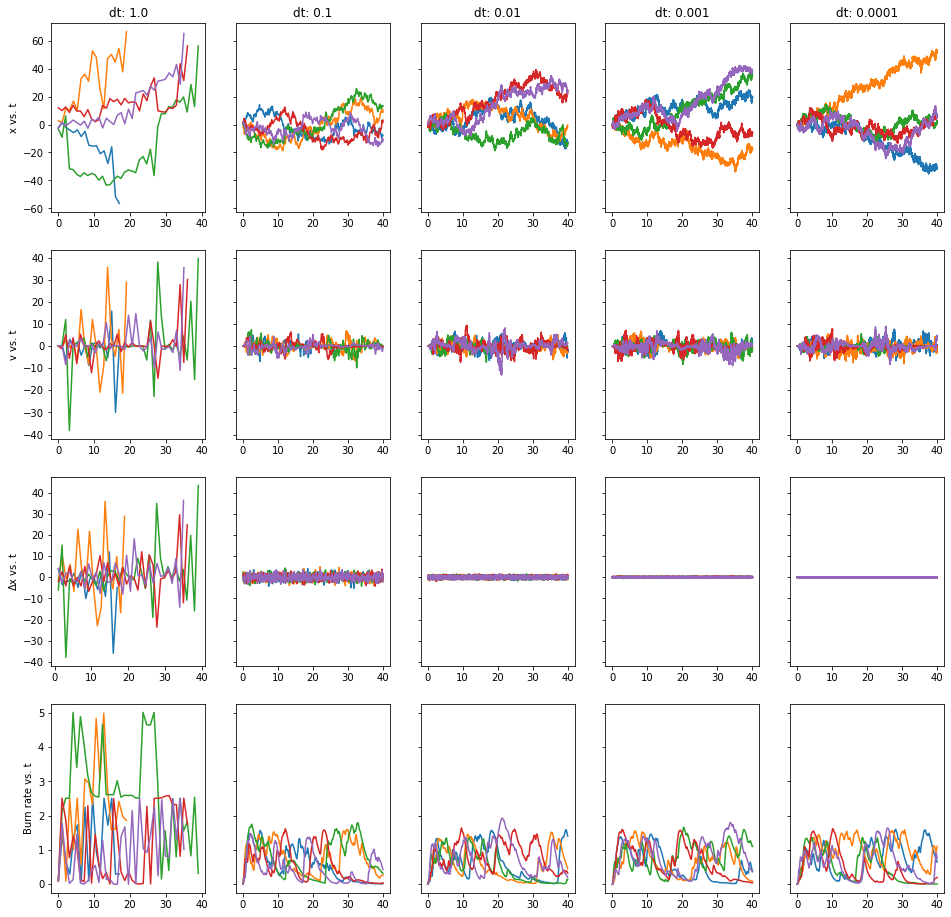

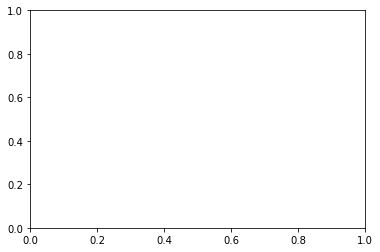

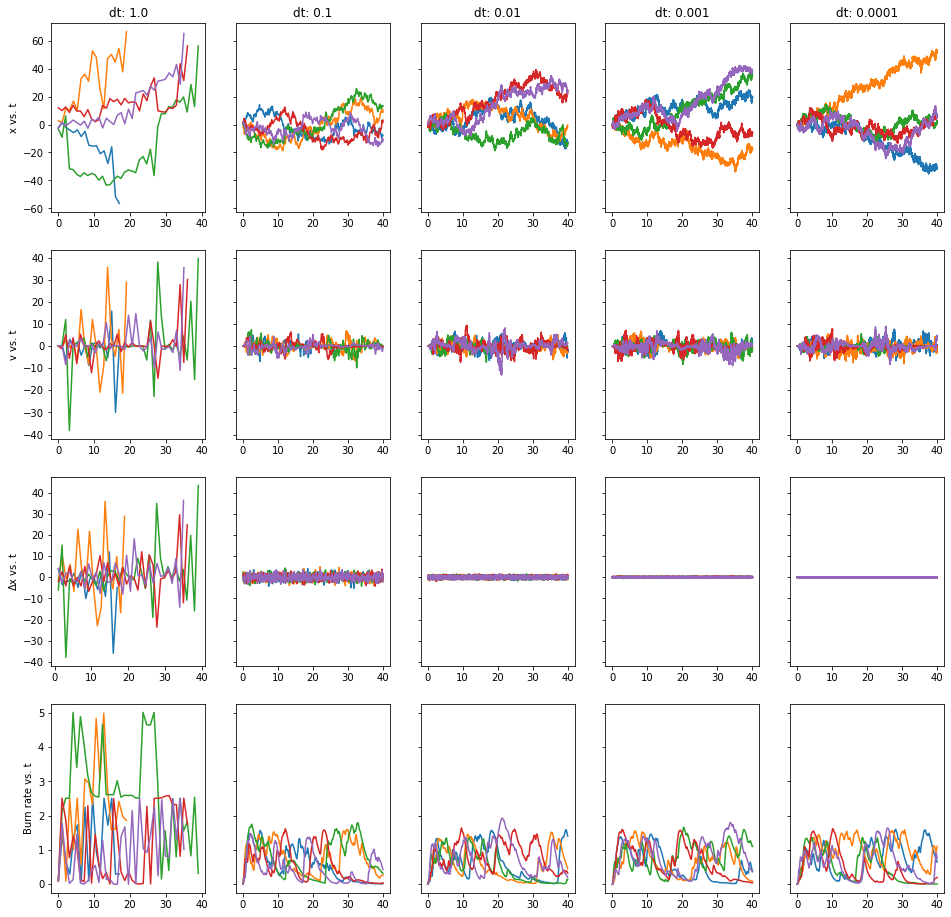

In [35]:
# vary dt

length = 60.0
Lmax = length
Lmin = -length
dx = 0.1
Nx = int((Lmax-Lmin)/dx) +1
xs = linspace(Lmin, Lmax, Nx)

run_n = 5
nu = 1.0


dts = logspace(0,-4,5,base =10)
dt_n = len(dts)

D = 10.0

for a0 in ones(1):
    ct = 0 
    display.clear_output(wait=True)
    cla()
    fig, axs = plt.subplots(4,dt_n,sharey ='row',figsize = (16,16))
    
    for dt in dts: 
        print(a0,dt)
        tf = 40.0
        t_max = int(tf/dt)
        for run in range(run_n):
            xp = 0.0
            Ac = zeros(Nx)
            As = zeros(Nx) 
            As[xs > 2.0] = a0
            As[xs < -2.0] =a0
            
            t_max = int(tf/dt)
            xp_t = []
            As_t = []
            Ac_t = []
            v_t = []
            burn_t = []
            noisescale = sqrt(2*dt*D)
            scan = 200
            for t in range(t_max): ## loop through for every time step
                ## first determine total force on hub
                xp_index = int((xp+length)/dx)
                total_f = trapz(-(xp -xs[xp_index-scan:xp_index+scan]) * Ac[xp_index-scan:xp_index+scan], x=xs[xp_index-scan:xp_index+scan])
                binding = exp(-0.5 * (xp - xs[xp_index-scan:xp_index+scan]) ** 2) * As[xp_index-scan:xp_index+scan]
                burnt = nu * Ac[xp_index-scan:xp_index+scan]
                Ac[xp_index-scan:xp_index+scan] += (binding - burnt) *dt
                As[xp_index-scan:xp_index+scan] += (- binding) * dt
                
                noise = noisescale* random.normal(0.0,1.0)
                xp += total_f * dt + noise 
                
                
                xp_t.append(xp)
                v_t.append(total_f)
                As_t.append(As.copy())
                Ac_t.append(Ac.copy())
                burn_t.append(trapz(Ac*nu,x=xs))
                

                if abs(xp) > length -5.0:
                    t_max = int(t)+1
                    break
                
            ts = linspace(0,t_max*dt,t_max)
            #suptitle("D: " +str(round(D,4)))
            axs[0][ct].plot(ts,xp_t)
            axs[0][ct].title.set_text("dt: "+str(round(dt,4)))
            axs[1][ct].plot(ts,v_t)
            axs[2][ct].plot(ts[1:],np.diff(array(xp_t)))
            axs[3][ct].plot(ts,burn_t)
            if ct == 0:
                axs[0][ct].set_ylabel('x vs. t')
                axs[1][ct].set_ylabel('v vs. t')
                axs[2][ct].set_ylabel('$\Delta$x vs. t')
                axs[3][ct].set_ylabel('Burn rate vs. t')
        
        ct += 1
    display.display(gcf())
    





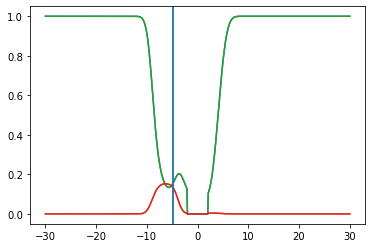

0.46680507659912107 0.4674002909660339 3.878842525626425e-06


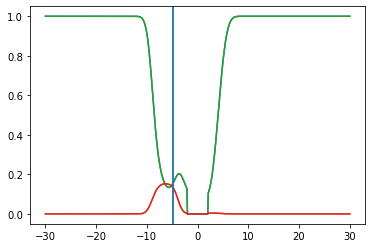

In [54]:
# compare computation time for between partial and full scan

length = 30.0
Lmax = length
Lmin = -length
dx = 0.1
Nx = int((Lmax-Lmin)/dx) +1
xs = linspace(Lmin, Lmax, Nx)

run_n = 100
nu = 1.0


dt = 0.001
D = 10.0

time1s = []
time2s = []
xp_diff=[]
for a0 in ones(1):
    tf = 4000.0
    t_max = int(tf/dt)
    for run in range(run_n):
        xp = 0.0
        Ac = zeros(Nx)
        As = zeros(Nx) 
        As[xs > 2.0] = a0
        As[xs < -2.0] =a0

        t_max = int(tf/dt)
        xp_t = []
        As_t = []
        Ac_t = []
        v_t = []
        burn_t = []
        
        xp2 = 0.0
        Ac2 = zeros(Nx)
        As2 = zeros(Nx) 
        As2[xs > 2.0] = a0
        As2[xs < -2.0] =a0

        xp_t2 = []
        As_t2 = []
        Ac_t2 = []
        v_t2 = []
        burn_t2 = []
        
        noisescale = sqrt(2*dt*D)
        scan = 200
        time1 = 0.0
        time2 = 0.0
        for t in range(t_max): ## loop through for every time step
            ## partial scanning
            start_time = time.time()
            xp_index = int((xp+length)/dx)
            total_f = trapz(-(xp -xs[xp_index-scan:xp_index+scan]) * Ac[xp_index-scan:xp_index+scan], x=xs[xp_index-scan:xp_index+scan])
            binding = exp(-0.5 * (xp - xs[xp_index-scan:xp_index+scan]) ** 2) * As[xp_index-scan:xp_index+scan]
            burnt = nu * Ac[xp_index-scan:xp_index+scan]
            Ac[xp_index-scan:xp_index+scan] += (binding - burnt) *dt
            As[xp_index-scan:xp_index+scan] += (- binding) * dt

            noise = noisescale* random.normal(0.0,1.0)
            xp += total_f * dt + noise 
            
            xp_t.append(xp)
            v_t.append(total_f)
            As_t.append(As.copy())
            Ac_t.append(Ac.copy())
            burn_t.append(trapz(Ac*nu,x=xs))
            
            time1 += time.time()-start_time
            

            start_time = time.time()
            total_f2 = trapz(-(xp2 -xs) * Ac2, x=xs)
            binding = exp(-0.5 * (xp2 - xs) ** 2) * As2
            burnt = nu * Ac2
            Ac2 += (binding - burnt) *dt
            As2 += (- binding) * dt

            xp2 += total_f2 * dt + noise 
            
            xp_t2.append(xp2)
            v_t2.append(total_f2)
            As_t2.append(As2.copy())
            Ac_t2.append(Ac2.copy())
            burn_t2.append(trapz(Ac2*nu,x=xs))
            
            time2 += time.time()-start_time
            
            if t % 1000 ==0 and run ==0:
                display.clear_output(wait=True)
                cla()
                plot(xs,As)
                plot(xs,Ac)
                axvline(xp)
                plot(xs,As2)
                plot(xs,Ac2)
                axvline(xp2)

                display.display(gcf())


            if abs(xp2) > length -20.0:
                t_max = int(t)+1
                time1s.append(time1)
                time2s.append(time2)
                xp_diff.append(abs(xp-xp2))
                break

print(mean(array(time1s),axis = 0), mean(array(time2s),axis = 0),mean(array(xp_diff),axis = 0))





In [57]:
# RMSD vs dt

# define domain and lattice
length = 60.0
Lmax = length
Lmin = -length
dx = 0.1
Nx = int((Lmax-Lmin)/dx) +1
xs = linspace(Lmin, Lmax, Nx)

run_n = 200
nu = 1.0
D_n = 5
Ds = logspace(-2,2,D_n,base = 10)
Ds = ones(1)*10
D_n = len(Ds)+1

dts = array([0.01,0.005,0.001,0.0005,0.0001])
dt1 = logspace(0,-1,10,base=10)
dt2 = logspace(-2,-3,3,base=10)
dt3 = logspace(-4,-4,1,base=10)
dts = concatenate((dt1,dt2,dt3))
dt_n = len(dts)
D = 1.0
print(dts)
for a0 in ones(1):
    ct = 0 
    rmsd = [0.0]
    xp_finals = []
    for dt in dts: 
        tf = 40.0

        work_run = []
        burn_run = []
        eff_run = []
        bean_run = []
        
        xp_final = []
        start_time = time.time()
        for run in range(run_n):

            xp = 0.0
            Ac = zeros(Nx)
            As = zeros(Nx) 
            As[xs > 2.0] = a0
            As[xs < -2.0] =a0
            
            t_max = int(tf/dt)
            xp_t = []
            As_t = []
            Ac_t = []
            v_t = []
            burn_t = []
            count = 0
            noisescale = sqrt(2*dt*D)
            if run % 10==0:
                print(run)
            scan = 200
            for t in range(t_max): ## loop through for every time step
                ## first determine total force on hub

                
                xp_index = int((xp+length)/dx)
                total_f = trapz(-(xp -xs[xp_index-scan:xp_index+scan]) * Ac[xp_index-scan:xp_index+scan], x=xs[xp_index-scan:xp_index+scan])
                binding = exp(-0.5 * (xp - xs[xp_index-scan:xp_index+scan]) ** 2) * As[xp_index-scan:xp_index+scan]
                burnt = nu * Ac[xp_index-scan:xp_index+scan]
                Ac[xp_index-scan:xp_index+scan] += (binding - burnt) *dt
                As[xp_index-scan:xp_index+scan] += (- binding) * dt
                noise = noisescale * random.normal(0.0,1.0)
                xp += total_f * dt + noise 
                
                
                xp_t.append(xp)
                v_t.append(total_f)
                As_t.append(As.copy())
                Ac_t.append(Ac.copy())
                burn_t.append(trapz(Ac*nu,x=xs))

                if abs(xp) > length -20.0:
                    t_max = int(t)+1
                    t_cut = int(t_max*0.5)
                    break
            xp_final.append(xp_t[-1])
            ts = linspace(0,t_max*dt,t_max)
        rmsd.append(sqrt(mean(array(xp_final)**2,axis=0)))
        xp_finals.append(xp_final)
        print(a0,dt,rmsd[-1], time.time()-start_time)
    





[1.00000000e+00 7.74263683e-01 5.99484250e-01 4.64158883e-01
 3.59381366e-01 2.78255940e-01 2.15443469e-01 1.66810054e-01
 1.29154967e-01 1.00000000e-01 1.00000000e-02 3.16227766e-03
 1.00000000e-03 1.00000000e-04]
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
1.0 1.0 28.190550155745523 0.5108277797698975
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
1.0 0.7742636826811271 16.656348300477937 0.7830531597137451
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
1.0 0.599484250318941 14.571655734321773 0.9051201343536377
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
1.0 0.4641588833612779 13.893517719630902 1.1769707202911377
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
1.0 0.35938136638046275 13.493252461454249 1.5223217010498047
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
1.0 0.2782559402207124 13.203061873217466 2.0929434299468994
0
10
20
30
40
50
60


In [58]:
print(rmsd)

[0.0, 28.190550155745523, 16.656348300477937, 14.571655734321773, 13.893517719630902, 13.493252461454249, 13.203061873217466, 13.13268464958876, 12.867125981855606, 14.262983811588066, 12.758322868603459, 12.326443252083488, 12.611171849890761, 13.572782180881095, 12.503889073228216]


Text(0, 0.5, 'RMSD')

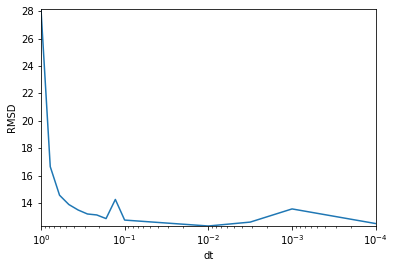

In [59]:
plot(dts,rmsd[1:])
plt.axis([max(dts),min(dts),min(rmsd[1:]),max(rmsd[1:])])
xscale("log")
xlabel("dt")
ylabel("RMSD")

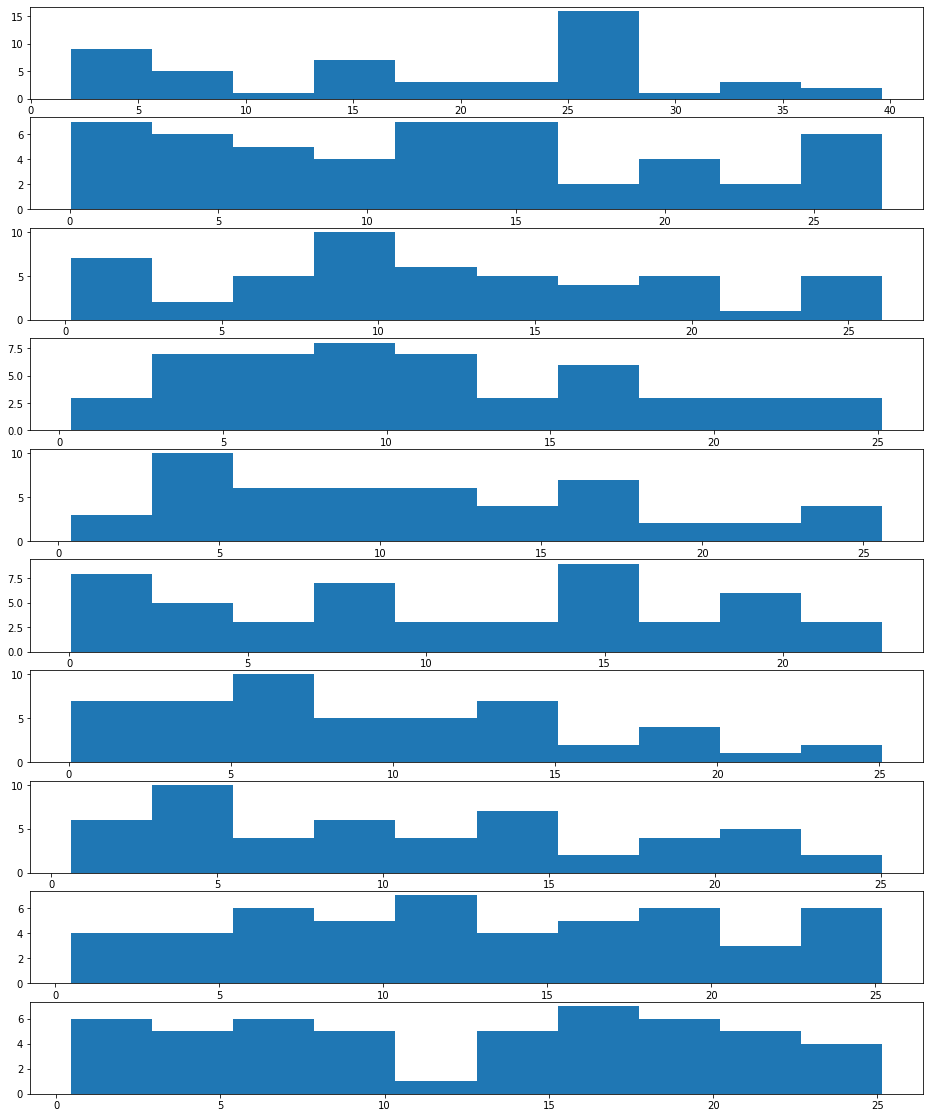

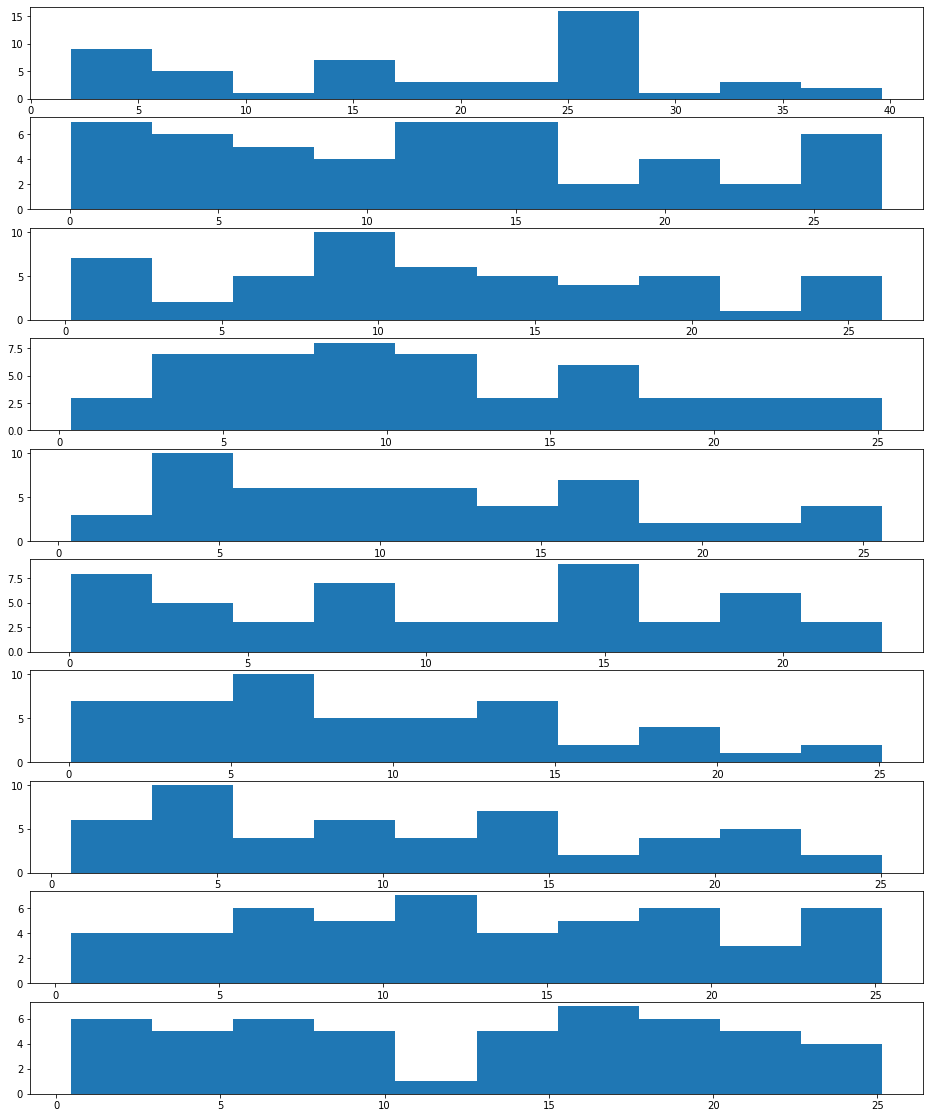

In [41]:
fig, axs = plt.subplots(int(dt_n/3),figsize = (16,20))
for i in range(0,dt_n,3):
    display.clear_output(wait=True)
    cla()
    axs[int(i/3)].hist(sqrt(array(xp_finals[i])**2))
    display.display(gcf())


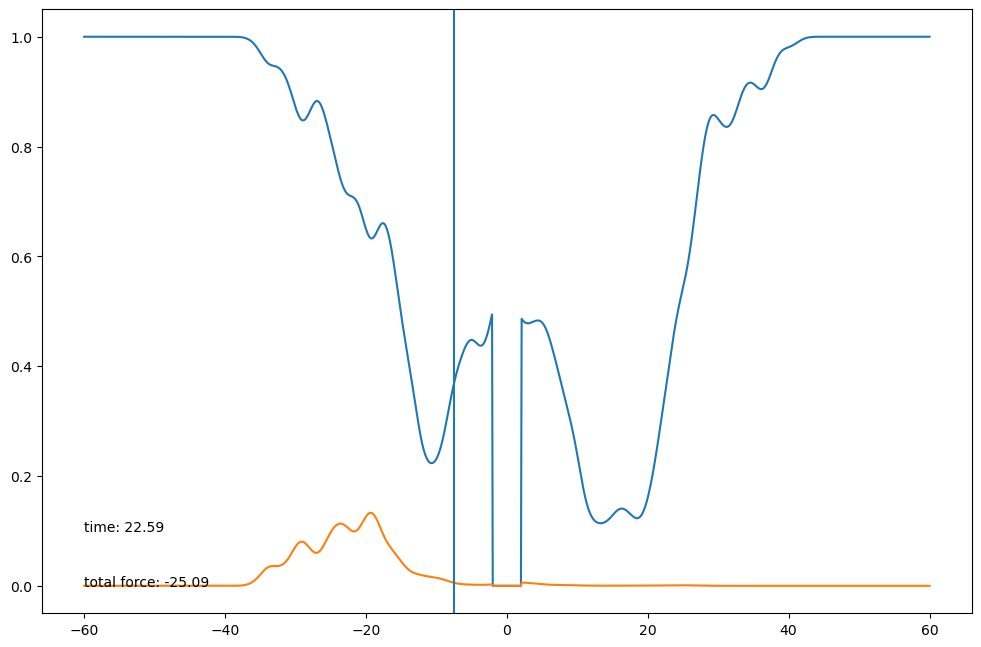

In [ ]:
# As, Ac profiles at large force D=100

length = 60.0
Lmax = length
Lmin = -length
dx = 0.1
Nx = int((Lmax-Lmin)/dx) +1
xs = linspace(Lmin, Lmax, Nx)

run_n = 100
nu = 1.0


dt = 0.001
D = 100.0

time1s = []
time2s = []
xp_diff=[]
for a0 in ones(1):
    tf = 4000.0
    t_max = int(tf/dt)
    for run in range(run_n):
        xp = 0.0
        Ac = zeros(Nx)
        As = zeros(Nx) 
        As[xs > 2.0] = a0
        As[xs < -2.0] =a0

        t_max = int(tf/dt)
        xp_t = []
        As_t = []
        Ac_t = []
        v_t = []
        burn_t = []
       
        
        noisescale = sqrt(2*dt*D)
        for t in range(t_max): ## loop through for every time step
            ## partial scanning
            xp_index = int((xp+length)/dx)
            total_f = trapz(-(xp -xs) * Ac, x=xs)
            binding = exp(-0.5 * (xp - xs) ** 2) * As
            burnt = nu * Ac
            Ac += (binding - burnt) *dt
            As += (- binding) * dt

            noise = noisescale* random.normal(0.0,1.0)
            xp += total_f * dt + noise 
            
            xp_t.append(xp)
            v_t.append(total_f)
            As_t.append(As.copy())
            Ac_t.append(Ac.copy())
            burn_t.append(trapz(Ac*nu,x=xs))
            
            
            
            if abs(total_f) > 10.0 and t%10==0:
                display.clear_output(wait=True)
                cla()
                fig=figure(figsize=(12,8))
                plot(xs,As)
                plot(xs,Ac)
                axvline(xp)
                text(-60.0,0.0,"total force: "+str(round(total_f,2)))
                text(-60.0,0.1,"time: "+str(round(t*dt,2)))

                display.display(gcf())


            if abs(xp) > length -5.0:
                t_max = int(t)+1
                break



